In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dysarthria-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2394508%2F4042447%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240403%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240403T141933Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc747d5caa4635f24fc84af312c6eabc2eb9a87ff386572d02bd3d876e31d59ea9e82e6dd4aadacadec282592de3db17852fba4530620a8ef4d02d4e9a3212e499aaaefbc03658af37150fa1e4e70909c5ad9b65d3c720ead1f9dd4bd7581a25e77cf9e7413c986cab3dc8cd6d845c54fab3becc7d6292564928ac0684529095f2ec9374f33483242e4b52a1e8e172ea50e72fa39011eef1339a2c4b95d5cf8408114cad25fcc2e3737607efd4a0409efeb61c87444759a9094559fbf2fdc2cd9b027a35cbb2d21c60a6fac2c421ff6d48fee560ae30d7f93947093e3c160bc8b8f94b8afece6b19271b256163b0cce92569bc6774cc12b70d22c8dfabcbbc9bd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 162985010 bytes downloaded
Downloaded and uncompressed: dysarthria-detection
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

In [ ]:
directory = '../input/dysarthria-detection'
data = pd.read_csv("../input/dysarthria-detection/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
1,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
2,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
3,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
4,non_dysarthria,female,../input/dysarthria-detection/torgo_data/non_d...
...,...,...,...
1995,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1996,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1997,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...
1998,dysarthria,male,../input/dysarthria-detection/torgo_data/dysar...


In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

In [ ]:
def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features.append(mean_mfcc)
        except EOFError:
            pass

    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    return dataf

In [ ]:
dataf = feature_extraction(data)
dataf

100%|██████████| 2000/2000 [00:40<00:00, 49.47it/s]


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-221.788269,101.259232,-16.548132,38.492065,-13.595653,20.772556,-5.536349,10.410690,1.962461,-0.799048,...,0.962193,0.744855,1.058080,0.388451,0.081758,0.546172,0.594357,0.170033,-0.219215,non_dysarthria
1,-299.520081,109.872574,-17.097267,38.854969,-16.881130,22.959133,1.824228,18.724186,3.448541,4.455821,...,1.105589,1.056284,1.252576,0.027333,-1.368948,-0.037859,0.020661,-0.082124,-0.744831,non_dysarthria
2,-302.950043,112.048477,-23.679882,44.887421,-22.434727,26.299335,0.811477,18.210291,4.344697,4.912156,...,0.844332,0.530004,1.018391,0.055385,-1.472088,0.295324,0.191228,-0.224301,-0.582725,non_dysarthria
3,-210.861603,116.504486,-35.046497,37.670425,-27.112514,25.593725,-7.511986,13.140750,-0.587347,4.138087,...,0.630752,0.898457,0.721398,0.174576,-0.090706,0.001523,0.360464,-0.075449,-0.259715,non_dysarthria
4,-280.227203,104.505035,-17.209877,45.064884,-15.542122,28.115065,-3.449209,16.841436,4.573242,1.738296,...,1.596206,0.970084,0.732015,0.547593,-0.152664,0.131893,-0.288228,-0.468570,-0.461726,non_dysarthria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-304.231995,115.359306,-0.794746,26.543352,-0.682190,13.183387,2.389221,4.290236,-1.372811,-2.624718,...,0.473923,0.103740,0.311737,0.015566,-0.055351,0.193023,0.332826,0.014455,-0.221991,dysarthria
1995,-457.822144,110.087799,22.221983,-0.056086,-11.181323,3.190089,-4.499060,4.474746,5.809545,-1.913331,...,0.622933,0.508349,0.398737,0.455839,0.348571,0.286893,0.150862,-0.052999,0.001199,dysarthria
1996,-371.546875,116.846909,5.667272,22.488144,8.221014,7.740132,8.989120,9.996635,4.383992,3.590931,...,0.240280,-0.009779,-0.018253,-0.014393,-0.263360,0.556257,0.749682,-0.283888,-0.398581,dysarthria
1997,-302.500702,112.511192,-4.506541,32.498363,-1.519380,4.109807,4.611475,9.744306,-2.962905,-3.497744,...,0.146675,-0.200982,0.388719,0.160434,-0.383473,0.417755,1.042827,-0.082762,-0.111990,dysarthria


In [ ]:
dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

In [ ]:
X.shape, y.shape

((1999, 128), (1999,))

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=101)
X_train, X_validation, y_train, y_validation = train_test_split(X_temp, y_temp, test_size=0.10, random_state=101)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)
X_validation = X_validation.reshape(-1,16,8,1)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Add
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import joblib

# Load VGG16 pre-trained on ImageNet without top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(55, 55, 3))

# Freeze the layers in the base model
for layer in vgg16_base.layers:
    layer.trainable = False

# Define the CNN layers
cnn_layers = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2))
])

# Combine base model with custom top layers
vgg16_model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),
    Resizing(55, 55),  # Resize the input to 55x55
    Conv2D(3, (3, 3), padding='same'),  # Convert grayscale to RGB
    cnn_layers,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
vgg16_model.summary()

# Callbacks
model_name = "vgg16_model.h5"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = vgg16_model.fit(X_train, y_train, epochs=50, validation_data=(X_validation, y_validation), callbacks=[checkpoint, earlystopping])

# Save the Keras model
vgg16_model.save("vgg16_model.h5")

# Save additional information using joblib
additional_info = {
    "preprocessing_steps": ["Resizing(55, 55)", "Conv2D(3, (3, 3), padding='same')"],
    "other_data": {"key": "value"}  # Replace this with your additional data
}

joblib.dump(additional_info, "additional_info.pkl")


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 55, 55, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 55, 55, 3)         30        
                                                                 
 sequential_4 (Sequential)   (None, 1, 1, 512)         1568576   
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

['additional_info.pkl']

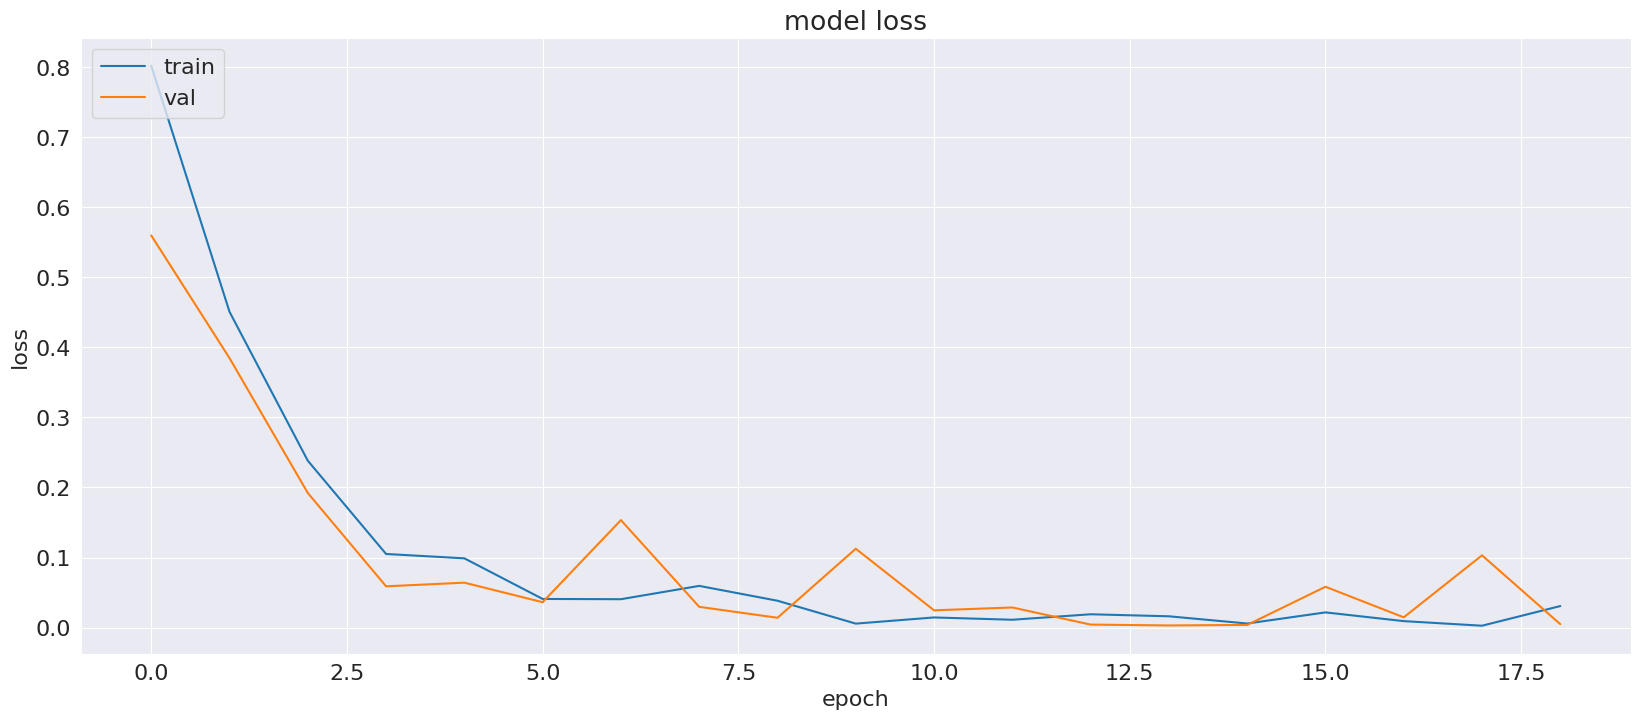

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

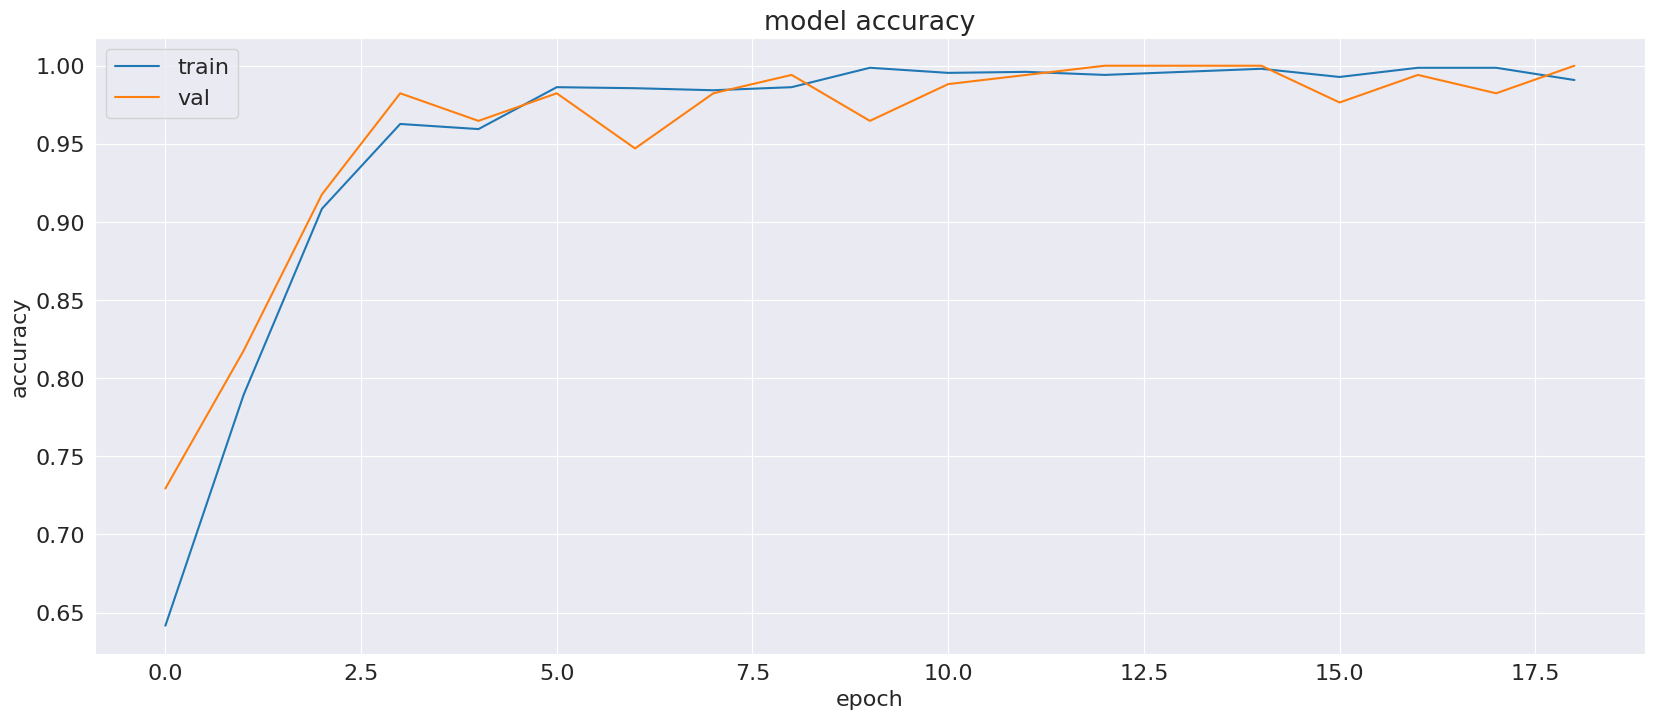

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = vgg16_model.predict(X_test)

10/10 [==============================] - 1s 74ms/step


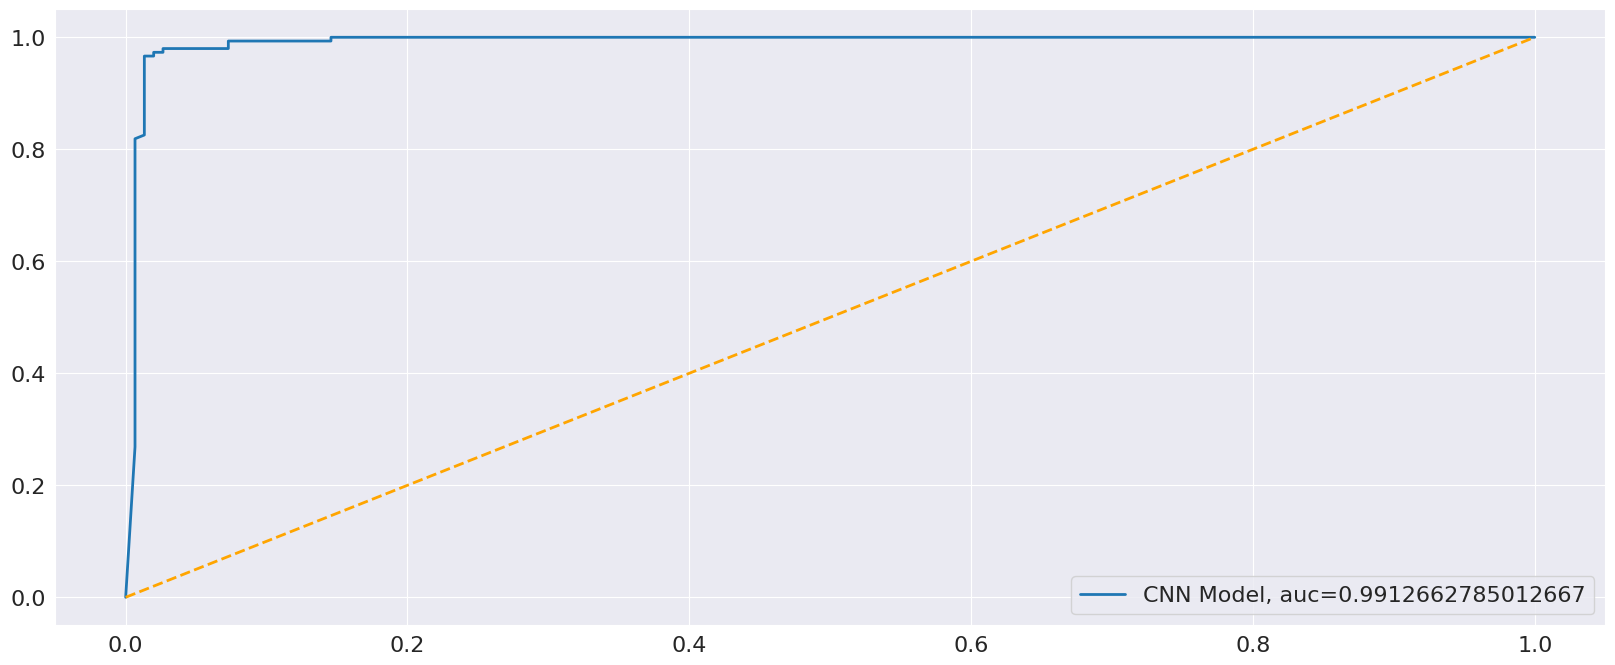

In [ ]:
plt.figure(figsize=(20,8))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

In [ ]:
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

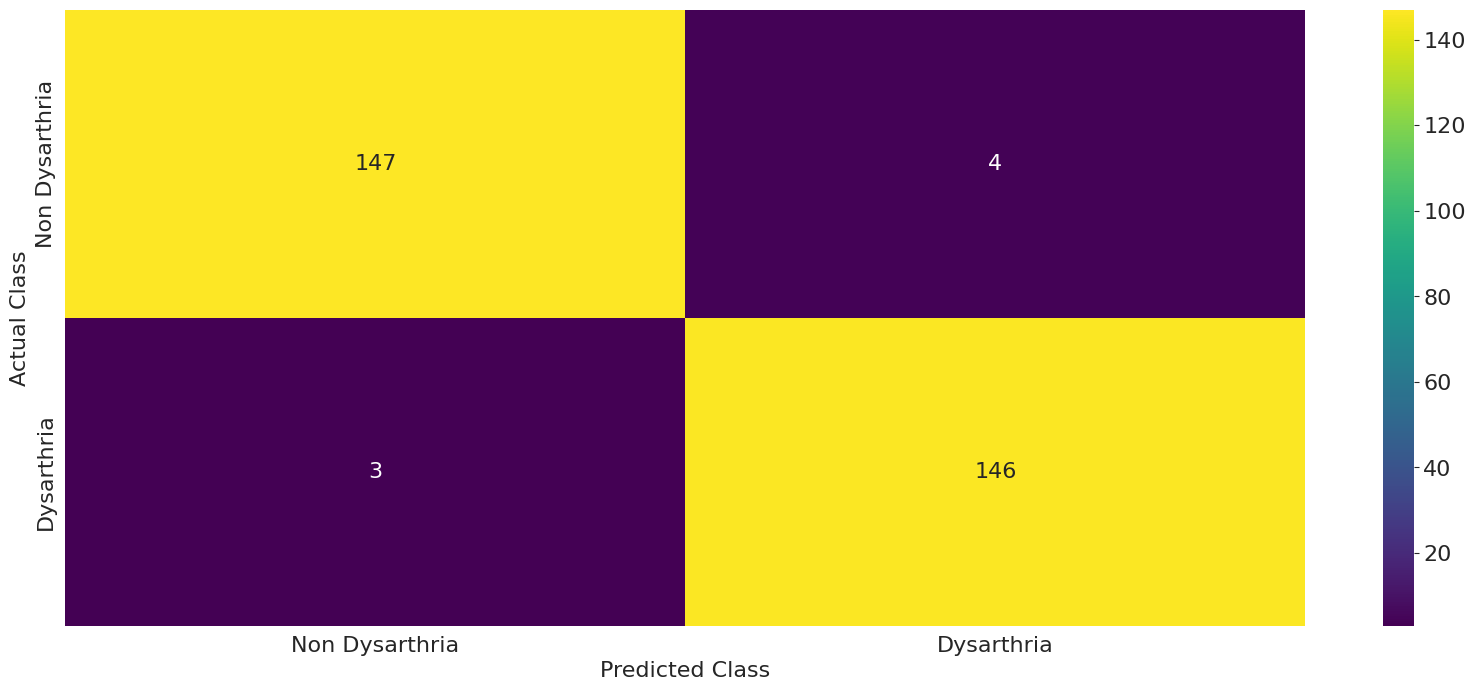

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       151
         1.0       0.97      0.98      0.98       149

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
print("Recall Score of the Model: ",recall_score(y_test,y_pred))

Recall Score of the Model:  0.9798657718120806
